<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#train.csv" data-toc-modified-id="train.csv-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>train.csv</a></span></li><li><span><a href="#test.csv" data-toc-modified-id="test.csv-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>test.csv</a></span></li><li><span><a href="#stores.csv" data-toc-modified-id="stores.csv-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>stores.csv</a></span></li><li><span><a href="#oil.csv" data-toc-modified-id="oil.csv-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>oil.csv</a></span></li><li><span><a href="#holidays_events.csv" data-toc-modified-id="holidays_events.csv-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>holidays_events.csv</a></span></li><li><span><a href="#transactions.csv" data-toc-modified-id="transactions.csv-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>transactions.csv</a></span></li></ul></li><li><span><a href="#Графики" data-toc-modified-id="Графики-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Графики</a></span><ul class="toc-item"><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Праздники" data-toc-modified-id="Праздники-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Праздники</a></span></li><li><span><a href="#Реклама-(promotion)" data-toc-modified-id="Реклама-(promotion)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Реклама (promotion)</a></span></li><li><span><a href="#Транзакции" data-toc-modified-id="Транзакции-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Транзакции</a></span></li><li><span><a href="#Нефть" data-toc-modified-id="Нефть-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Нефть</a></span></li></ul></li><li><span><a href="#Дополнительные-признаки-и-создание-модели-обучения" data-toc-modified-id="Дополнительные-признаки-и-создание-модели-обучения-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Дополнительные признаки и создание модели обучения</a></span></li></ul></div>

In [111]:
import numpy as np
import pandas as pd  

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats
from itertools import product

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate

from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

## `train.csv`

Обучающие данных, представляющие временные ряды.
- **store_nbr** - номер магазина, в котором продаются товары.
- **family** - группа проданного товара.
- **onpromotion** - общее количество товаров в группе, которые рекламировались в магазине на заданную дату.
- **sales** - целевой признак, отражающий продажи группы товаров в определенном магазине на заданную дату. 

In [27]:
train = pd.read_csv(
    'train.csv', parse_dates=['date'],
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    infer_datetime_format=True
)
store_sales = train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

prom = (store_sales.groupby('date').mean().squeeze())['onpromotion'].to_frame()
average_sales = (store_sales.groupby('date').mean().squeeze())['sales'].to_frame()

In [28]:
train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [29]:
prom.tail()

,onpromotion
date,
2017-08-11,7.956790
2017-08-12,4.664422
2017-08-13,5.209315
2017-08-14,4.513468
2017-08-15,5.951178


## `test.csv`

Содержит такие же признаки, что и `train`, за исключением целевого признака, который и надо предсаказать на следующие 15 дней после последней даты в `train`.

In [30]:
test = pd.read_csv(
    'test.csv',
    usecols=['store_nbr', 'family', 'date', 'onpromotion'],
    parse_dates=['date'], infer_datetime_format=True
)

In [31]:
test.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


## `stores.csv`

Сведения о магазинах:
- **city** - город
- **state** - штат
- **type** - тип
- **cluster** - группа похожих магазинов

In [32]:
stores = pd.read_csv('stores.csv', index_col='store_nbr')

In [33]:
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## `oil.csv`

Ежедневная цена на нефть.\
Включает значения как для обучающих, так и для тестовых периодов данных.(Эквадор - страна, зависящая от нефти, и ее экономическое здоровье очень уязвимо к скачкам цен на нефть.)

In [34]:
oil = pd.read_csv('oil.csv', parse_dates=['date'],
                  infer_datetime_format=True)
oil = oil.set_index('date')

In [35]:
oil.tail()

,dcoilwtico
date,
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46
2017-08-30,45.96
2017-08-31,47.26


## `holidays_events.csv`

Данные по праздникам и событиям.
- **type** - тип события/праздника
- **locale** - территория действия праздника(местный, региональный, национальный)
- **locale_name** - название территории на которой проходит праздник
- **description** - название праздника
- **transferred** - если праздник перенесен на другую дату, то значение = True

In [36]:
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays = holidays.set_index('date').to_period('D')

In [37]:
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## `transactions.csv`

Данные о транзакциях. Содержат только период обучающей выборки.

In [38]:
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
transactions = transactions.set_index('date').to_period('d')
transactions.tail()

,store_nbr,transactions
date,,
2017-08-15,50,2804
2017-08-15,51,1573
2017-08-15,52,2255
2017-08-15,53,932
2017-08-15,54,802


# Графики

## Сезонность

In [40]:
sales_plot = average_sales.copy()

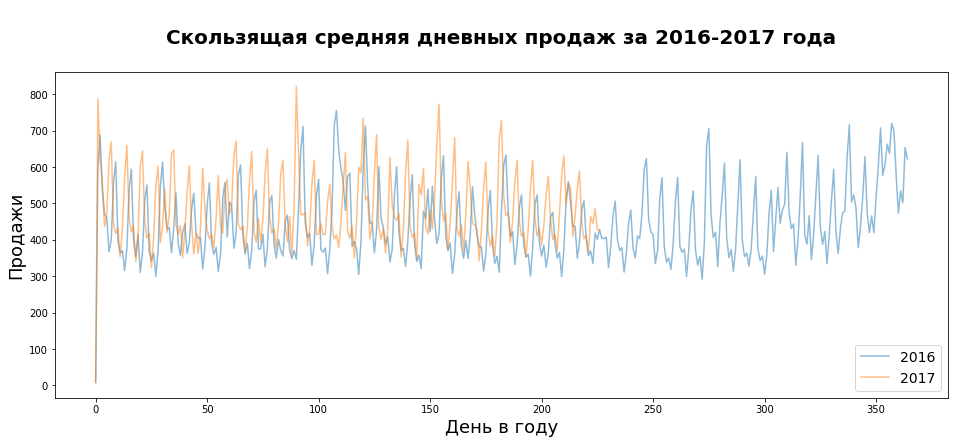

In [41]:
plt.figure(figsize=(16,6))
plt.title('\nСкользящая средняя дневных продаж за 2016-2017 года\n', fontweight="bold", fontsize=20)
plt.xlabel('День в году', fontsize=18)
plt.ylabel('Продажи', fontsize=18)
plt.plot(sales_plot.loc['2016']['sales'].values, label='2016', alpha=0.5)
plt.plot(sales_plot.loc['2017']['sales'].values, label='2017', alpha=0.5)
plt.legend(fontsize=14);

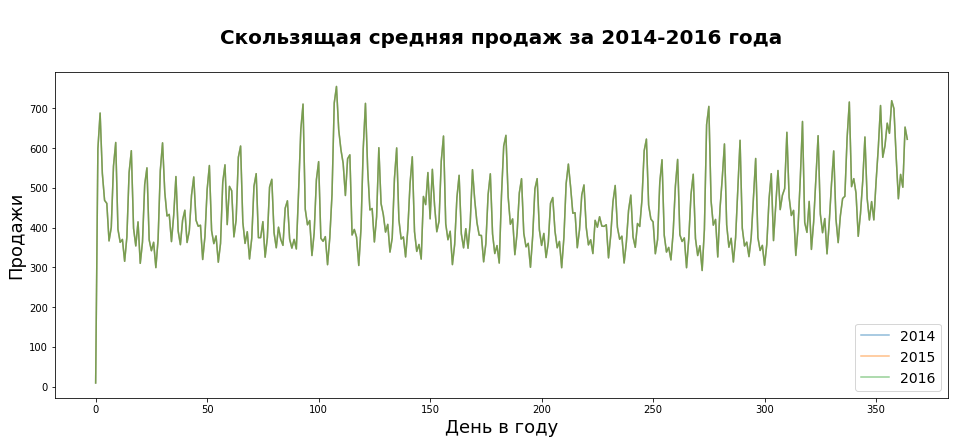

In [42]:
plt.figure(figsize=(16,6))
plt.title('\nСкользящая средняя продаж за 2014-2016 года\n', fontweight="bold", fontsize=20)
plt.xlabel('День в году', fontsize=18)
plt.ylabel('Продажи', fontsize=18)
plt.plot(sales_plot.loc['2016']['sales'].values, label='2014', alpha=0.5)
plt.plot(sales_plot.loc['2016']['sales'].values, label='2015', alpha=0.5)
plt.plot(sales_plot.loc['2016']['sales'].values, label='2016', alpha=0.5)
plt.legend(fontsize=14);

Судя по всему, годовые данные за период с `2014-2016` гг повторяются.

In [51]:
days = sales_plot.copy()
days['dayofweek'] = days.index.dayofweek

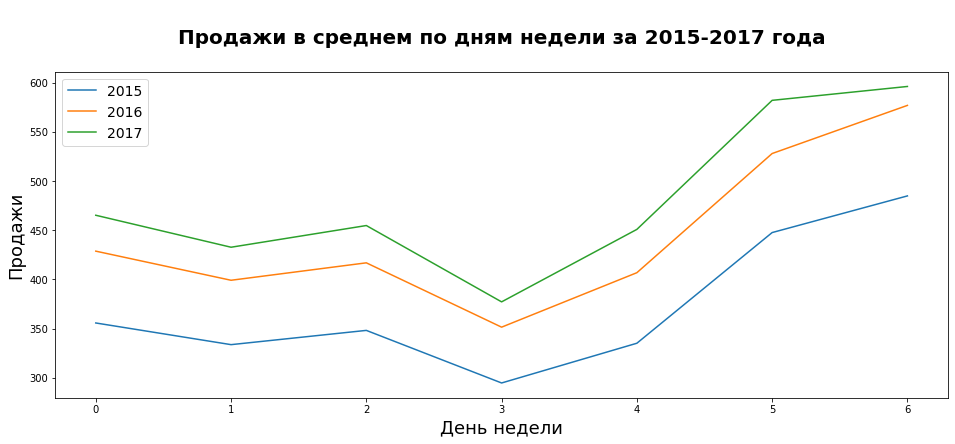

In [52]:
plt.figure(figsize=(16,6))
plt.title('\nПродажи в среднем по дням недели за 2015-2017 года\n', fontweight="bold", fontsize=20)
plt.xlabel('День недели', fontsize=18)
plt.ylabel('Продажи', fontsize=18)
plt.plot(days.loc['2015'].groupby('dayofweek')['sales'].mean().values, label='2015')
plt.plot(days.loc['2016'].groupby('dayofweek')['sales'].mean().values, label='2016')
plt.plot(days.loc['2017'].groupby('dayofweek')['sales'].mean().values, label='2017')
plt.legend(fontsize=14);

dayofweek
0    13.850459
1    12.882804
2    13.539237
3    11.229417
4    13.422832
5    17.327749
6    17.747501
Name: sales, dtype: float64

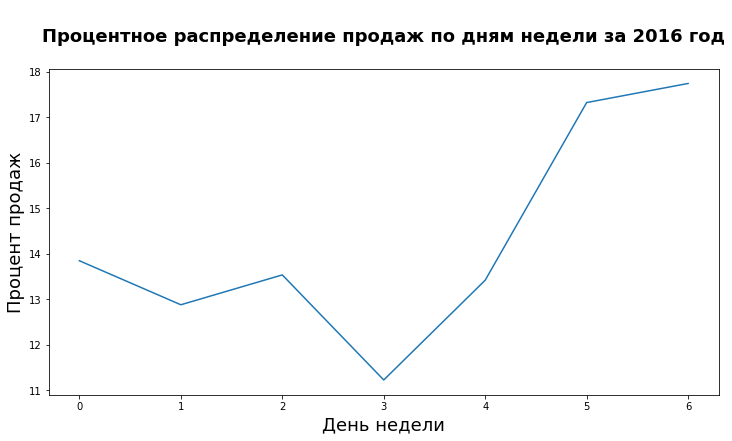

In [53]:
percent_days = days.loc['2017'].groupby('dayofweek')['sales'].mean()
percent_days = percent_days.map(lambda x: x * 100 / percent_days.sum())

plt.figure(figsize=(12,6))
plt.title('\nПроцентное распределение продаж по дням недели за 2016 год\n', fontweight="bold", fontsize=18)
plt.xlabel('День недели', fontsize=18)
plt.ylabel('Процент продаж', fontsize=18)
plt.plot(percent_days)
percent_days

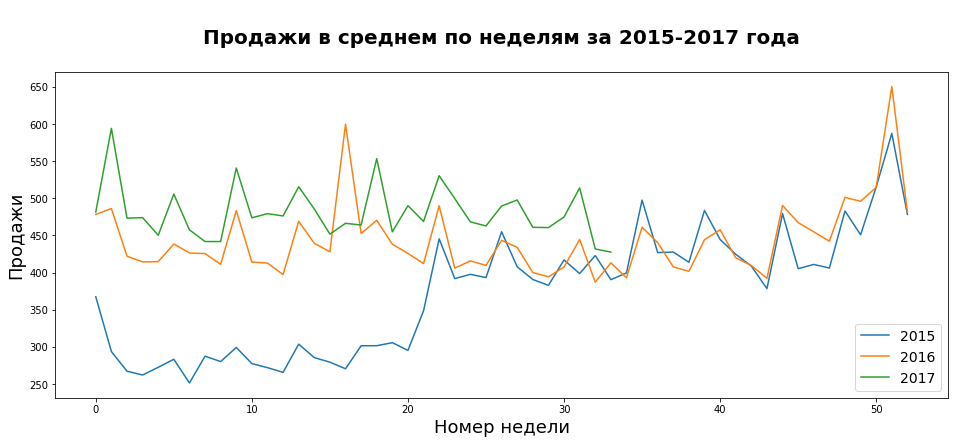

In [54]:
week = sales_plot.resample('w').mean()
plt.figure(figsize=(16,6))
plt.title('\nПродажи в среднем по неделям за 2015-2017 года\n', fontweight="bold", fontsize=20)
plt.xlabel('Номер недели', fontsize=18)
plt.ylabel('Продажи', fontsize=18)
plt.plot(week.loc['2015']['sales'].values, label='2015')
plt.plot(week.loc['2016']['sales'].values, label='2016')
plt.plot(week.loc['2017']['sales'].values, label='2017')
plt.legend(fontsize=14);

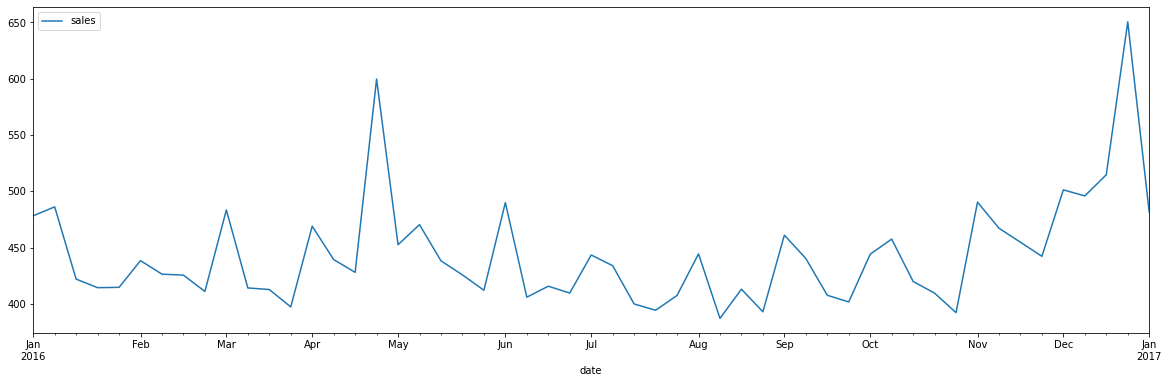

In [55]:
week.loc['2016'].plot(figsize=(20,6));

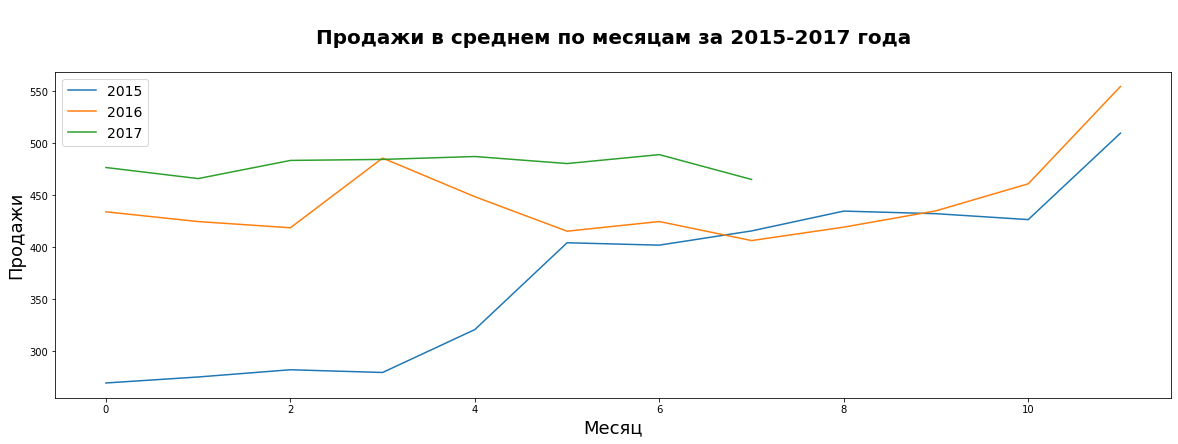

In [56]:
month = sales_plot.resample('m').mean()
plt.figure(figsize=(20,6))
plt.title('\nПродажи в среднем по месяцам за 2015-2017 года\n', fontweight="bold", fontsize=20)
plt.xlabel('Месяц', fontsize=18)
plt.ylabel('Продажи', fontsize=18)
plt.plot(month.loc['2015']['sales'].values, label='2015')
plt.plot(month.loc['2016']['sales'].values, label='2016')
plt.plot(month.loc['2017']['sales'].values, label='2017')
plt.legend(fontsize=14);

## Праздники

In [57]:
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [58]:
holidays.type.value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [59]:
holidays.locale.value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

## Реклама (promotion)

In [70]:
scale = MinMaxScaler()

Корреляция:  0.14


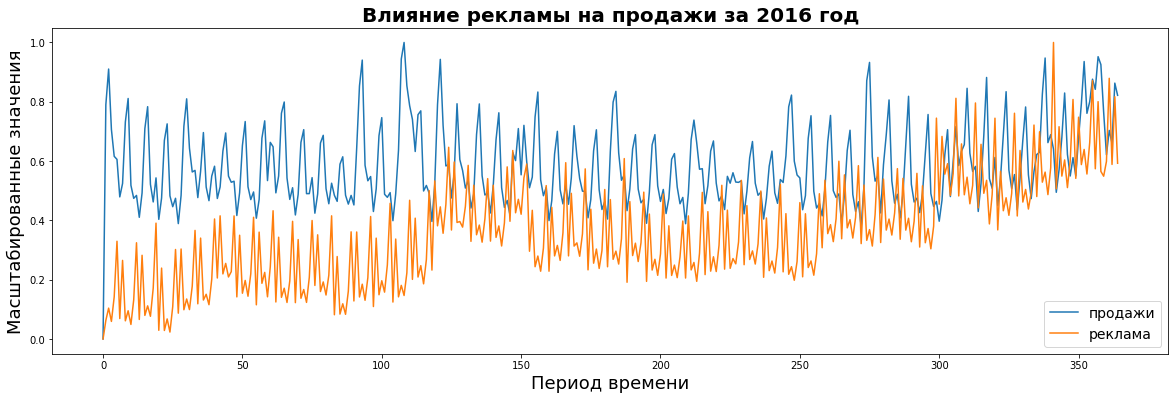

In [71]:
plt.figure(figsize=(20,6))
plt.title('Влияние рекламы на продажи за 2016 год', fontweight="bold", fontsize=20)
plt.xlabel('Период времени', fontsize=18)
plt.ylabel('Масштабированные значения', fontsize=18)
plt.plot(scale.fit_transform(sales_plot.loc['2016'].values), label='продажи')
plt.plot(scale.fit_transform(prom.loc['2016'].values), label='реклама')
plt.legend(fontsize=14);
print('Корреляция: ', round(prom.loc['2016'].corrwith(sales_plot.loc['2016'].sales).values[0], 2))

Корреляция:  0.15


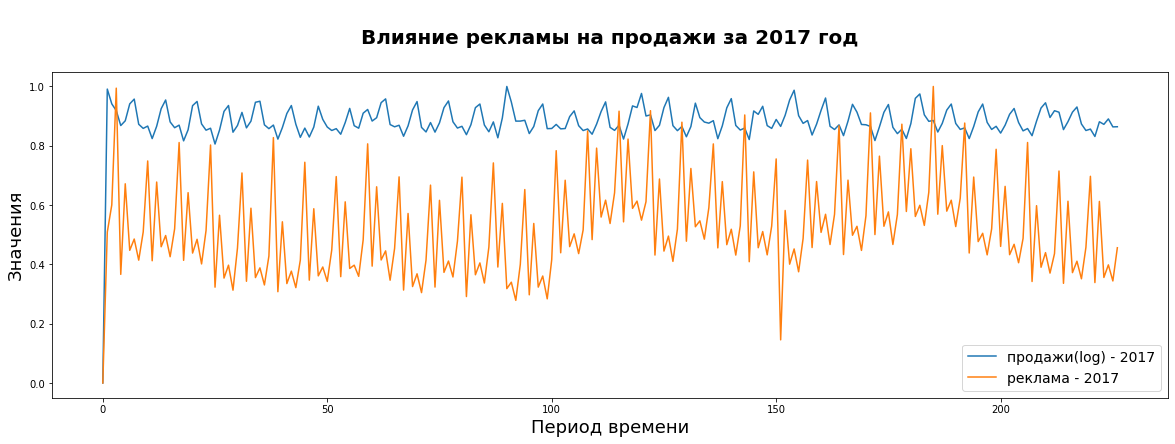

In [72]:
plt.figure(figsize=(20,6))
plt.title('\nВлияние рекламы на продажи за 2017 год\n', fontweight="bold", fontsize=20)
plt.xlabel('Период времени', fontsize=18)
plt.ylabel('Значения', fontsize=18)
plt.plot(scale.fit_transform(np.log(sales_plot.loc['2017'].values)), label='продажи(log) - 2017')
plt.plot(scale.fit_transform(prom.loc['2017'].values), label='реклама - 2017')

plt.legend(fontsize=14);
print('Корреляция: ', round((prom.loc['2017']).corrwith(np.log(sales_plot.loc['2017'].sales)).values[0], 2))

## Транзакции

Корреляция:  0.84


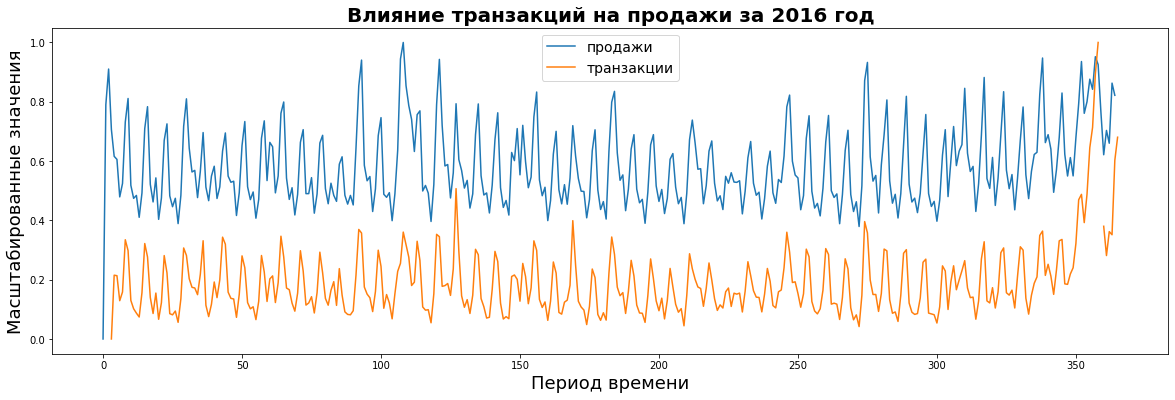

In [73]:
trans = transactions.resample('d').mean()['transactions'].to_frame()
plt.figure(figsize=(20,6))
plt.title('Влияние транзакций на продажи за 2016 год', fontweight="bold", fontsize=20)
plt.xlabel('Период времени', fontsize=18)
plt.ylabel('Масштабированные значения', fontsize=18)
plt.plot(scale.fit_transform(sales_plot.loc['2016'].values), label='продажи')
plt.plot(scale.fit_transform(trans.loc['2016'].values), label='транзакции')
plt.legend(fontsize=14);
print('Корреляция: ', round(trans.loc['2016'].corrwith(sales_plot.loc['2016'].sales).values[0], 2))

## Нефть

Корреляция:  nan


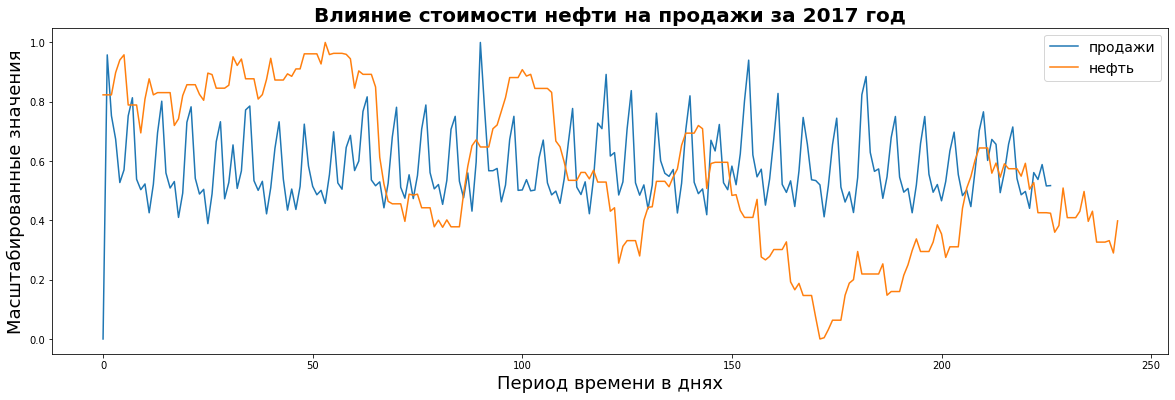

In [74]:
oils = oil.resample('d').mean().fillna(method='bfill')
plt.figure(figsize=(20,6))
plt.title('Влияние стоимости нефти на продажи за 2017 год', fontweight="bold", fontsize=20)
plt.xlabel('Период времени в днях', fontsize=18)
plt.ylabel('Масштабированные значения', fontsize=18)
plt.plot(scale.fit_transform(sales_plot.loc['2017'].values), label='продажи')
plt.plot(scale.fit_transform(oils.loc['2017'].values), label='нефть')
plt.legend(fontsize=14);
print('Корреляция: ', round(oils.loc['2017'].corrwith(sales_plot.loc['2017'].sales).values[0], 2))

# Дополнительные признаки и создание модели обучения

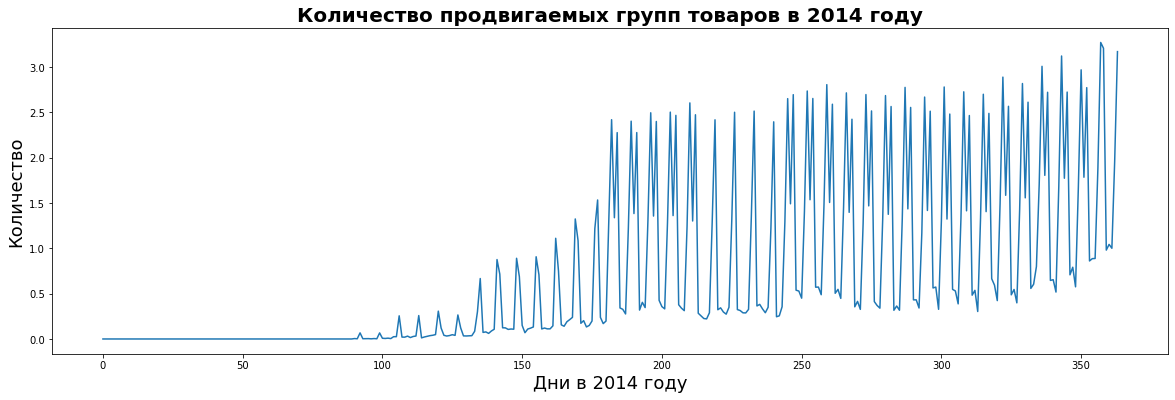

In [75]:
plt.figure(figsize=(20,6))
plt.title('Количество продвигаемых групп товаров в 2014 году', fontweight="bold", fontsize=20)
plt.xlabel('Дни в 2014 году', fontsize=18)
plt.ylabel('Количество', fontsize=18)
plt.plot(prom.loc['2014'].values);

Как видно из графика, продвигать товары стали только в `2014` году, поэтому имеет смысл обрезать данные и сделать обучающую выборку с начала `2015` года.

In [76]:
train = train[train.date >= '2016']

In [77]:
train

,date,store_nbr,family,sales,onpromotion
1945944,2016-01-01,1,AUTOMOTIVE,0.000,0
1945945,2016-01-01,1,BABY CARE,0.000,0
1945946,2016-01-01,1,BEAUTY,0.000,0
1945947,2016-01-01,1,BEVERAGES,0.000,0
1945948,2016-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Также, ранее было замечено, что в начале январские праздников продажи на нуле, их имеет смысл тоже удалить.

In [78]:
del_days = train[(
    (train.date.dt.month == 1) & (train.date.dt.day == 1)
) | (
    (train.date.dt.month == 1) & (train.date.dt.day == 2)
)].date

train = train.drop(del_days.index)

Cоздадим фрейм с дополнительными признаками

In [79]:
calendar = pd.DataFrame(index=pd.date_range('2016-01-03', '2017-08-31'))

Присоединим цены и скользящую среднюю по цене на нефть, заполним пустоты

In [80]:
# Корреляция никакая, поэтому врядли нам это нужно

oil['ma_oil'] = oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.merge(oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='bfill', inplace=True)
calendar['dcoilwtico'].fillna(method='bfill', inplace=True)


Добавим сезонность

In [81]:
calendar['dayofweek'] = calendar.index.dayofweek
calendar['weekofyear'] = calendar.index.weekofyear
calendar['monthofyear'] = calendar.index.month
calendar['dayofyear'] = calendar.index.dayofyear


Профильтруем праздники

In [83]:
holidays = pd.read_csv("holidays_events.csv", parse_dates=['date'],
                       infer_datetime_format=True)

In [84]:
holidays = holidays.set_index('date').sort_index()
holidays.index.name = ''

# оставим региональные и национальные праздники, удалим перенесенные

holidays = holidays[(holidays.locale == 'National') &
                    (holidays.type == 'Holiday') & (holidays.transferred == False)]

holidays = holidays.groupby(holidays.index).first() # удалим дни дубликаты

Добавим праздники к календарю

In [85]:
calendar = calendar.merge(holidays, how='left', left_index=True, right_index=True)

In [86]:
calendar['holiday'] = False
calendar.loc[calendar.type == 'Holiday', 'holiday'] = True

Определим рабочие дни

In [87]:
calendar['workday'] = True
calendar.loc[calendar.dayofweek > 4, 'workday'] = False

calendar.loc[calendar.type == 'Holiday', 'workday'] = False

In [88]:
calendar

,dcoilwtico,ma_oil,dayofweek,weekofyear,monthofyear,dayofyear,type,locale,locale_name,description,transferred,holiday,workday
2016-01-03,36.81,33.582857,6,53,1,3,NaN,NaN,NaN,NaN,NaN,False,False
2016-01-04,36.81,33.582857,0,1,1,4,NaN,NaN,NaN,NaN,NaN,False,True
2016-01-05,35.97,33.582857,1,1,1,5,NaN,NaN,NaN,NaN,NaN,False,True
2016-01-06,33.97,33.582857,2,1,1,6,NaN,NaN,NaN,NaN,NaN,False,True
2016-01-07,33.29,33.582857,3,1,1,7,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,46.40,47.624286,6,34,8,239,NaN,NaN,NaN,NaN,NaN,False,False
2017-08-28,46.40,47.624286,0,35,8,240,NaN,NaN,NaN,NaN,NaN,False,True
2017-08-29,46.46,47.320000,1,35,8,241,NaN,NaN,NaN,NaN,NaN,False,True
2017-08-30,45.96,47.115714,2,35,8,242,NaN,NaN,NaN,NaN,NaN,False,True


In [89]:
calendar = calendar.reset_index()
calendar.rename(columns={'index':'date'}, inplace=True)
calendar = calendar[['date', 'dayofweek', 'holiday', 'dayofyear']] # используем только день в году и день недели

In [90]:
train = train.merge(calendar, how='left', on='date')
test = test.merge(calendar, how='left', on='date')
train = train.merge(stores[['type', 'cluster']], how='left', on='store_nbr')
test = test.merge(stores[['type', 'cluster']], how='left', on='store_nbr')

In [91]:
train.set_index('date', inplace=True)

In [92]:
test.set_index('date', inplace=True)

In [93]:
train['sales'] = np.log(train.sales)
train.loc[train['sales'] == np.NINF, 'sales'] = 0

In [94]:
train.index = train.index.to_period('D')
test.index = test.index.to_period('D')

Разделим на обучающую и валидационную выборку

In [95]:
# нормализация значений

def normal(dataframe):
    df = dataframe.copy()
    columns = ['onpromotion']
    x = df[columns].values
    x_scaled = scale.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=columns, index = df.index)
    df[columns] = df_temp
    return df

In [96]:
df = train.copy()
trn = df[(df.index < '2017-08-01')]
vld = df[df.index >= '2017-08-01']

In [97]:
df

,store_nbr,family,sales,onpromotion,dayofweek,holiday,dayofyear,type,cluster
date,,,,,,,,,
2016-01-03,1,AUTOMOTIVE,0.000000,0,6,False,3,D,13
2016-01-03,1,BABY CARE,0.000000,0,6,False,3,D,13
2016-01-03,1,BEAUTY,0.693147,0,6,False,3,D,13
2016-01-03,1,BEVERAGES,6.954639,1,6,False,3,D,13
2016-01-03,1,BOOKS,0.000000,0,6,False,3,D,13
...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,6.082523,0,1,False,227,B,6
2017-08-15,9,PREPARED FOODS,5.040537,1,1,False,227,B,6
2017-08-15,9,PRODUCE,7.791411,148,1,False,227,B,6


In [98]:
X_vld = vld.drop('sales', axis=1)
y_vld = pd.DataFrame(vld[['store_nbr', 'family','sales']], index=X_vld.index)

In [99]:
X_trn = trn.drop('sales', axis=1)
y_trn = pd.DataFrame(trn[['store_nbr', 'family','sales']], index=X_trn.index)


In [100]:
X_vld = normal(X_vld)
X_trn = normal(X_trn)

In [101]:
y_vld

,store_nbr,family,sales
date,,,
2017-08-01,1,AUTOMOTIVE,1.609438
2017-08-01,1,BABY CARE,0.000000
2017-08-01,1,BEAUTY,1.386294
2017-08-01,1,BEVERAGES,7.873598
2017-08-01,1,BOOKS,0.000000
...,...,...,...
2017-08-15,9,POULTRY,6.082523
2017-08-15,9,PREPARED FOODS,5.040537
2017-08-15,9,PRODUCE,7.791411


Делаем `one-hot-encoding`.

In [102]:
X_vld = pd.get_dummies(X_vld, columns=['dayofweek', 'type', 'cluster'])
X_trn = pd.get_dummies(X_trn, columns=['dayofweek', 'type', 'cluster'])

In [103]:
X_trn = X_trn.reset_index()
X_vld = X_vld.reset_index()

In [112]:
# fourier = CalendarFourier(freq='D', order=4)

# dp = DeterministicProcess(index=y_trn.index.unique(),
#                           constant=False,
#                           order=1,
#                           seasonal=True,
#                           additional_terms=[fourier],
#                           drop=True)
# X_t = dp.in_sample()
# X_trn = X_trn.merge(X_t, how='left', on='date')
# X_v = dp.out_of_sample(steps=15)
# X_v.index.name = 'date'
# X_vld = X_vld.merge(X_v, how='left', on='date')


In [113]:
X_trn = X_trn.set_index(['date', 'store_nbr', 'family']).sort_index()
X_vld = X_vld.set_index(['date', 'store_nbr', 'family']).sort_index()

y_vld = y_vld.reset_index().set_index(['store_nbr','date', 'family']).sort_index()
y_trn = y_trn.reset_index().set_index(['store_nbr','date', 'family']).sort_index()

In [114]:
X_trn.shape

(1021086, 32)

In [115]:
X_vld.shape

(26730, 32)

In [116]:
df.shape

(1047816, 9)

RMLSE:  0.6390795611628429
CPU times: user 6min 14s, sys: 1.48 s, total: 6min 16s
Wall time: 6min 18s


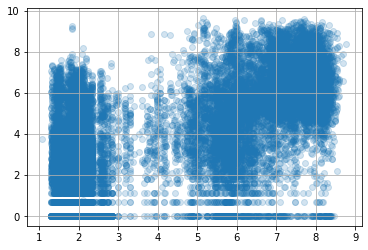

In [122]:
%%time

model = RandomForestRegressor()

model.fit(X_trn, y_trn)
y_pred = model.predict(X_vld)
y_pred = y_pred.clip(0.)

print('RMLSE: ', mean_squared_log_error(y_vld.sales, y_pred, squared=False))
plt.scatter(y_pred, y_vld, alpha=0.2);

plt.grid(True)

In [120]:
%%time

model = Lasso(alpha=0.1)

model.fit(X_trn, y_trn)
y_pred = model.predict(X_vld)
y_pred = y_pred.clip(0.)

print('RMLSE: ', mean_squared_log_error(y_vld.sales, y_pred, squared=False))

RMLSE:  0.7581218519716177
CPU times: user 3.18 s, sys: 166 ms, total: 3.34 s
Wall time: 4.9 s


In [121]:
%%time

lnr = LinearRegression()

lnr.fit(X_trn, y_trn.sales)
y_pred = lnr.predict(X_vld)
y_pred = y_pred.clip(0.)

print('RMLSE: ', mean_squared_log_error(y_vld.sales, y_pred, squared=False))

RMLSE:  0.6853284198410586
CPU times: user 4.22 s, sys: 367 ms, total: 4.58 s
Wall time: 5.49 s


проверим модели на тестовой выборке